In [1]:
import torch
import torchvision
from PIL import Image
import pandas as pd
import pickle
import glob
import os
from torchvision.models import resnet50
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from matplotlib.patches import Rectangle
import cv2
from sklearn.metrics import precision_recall_curve, auc



from SimSiam.simsiam.fastsiam import *
from train_fasterrcnn import *

In [2]:
class ZenseactLabeledDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.n_samples = len(data)

    def __getitem__(self, index):
        img = self.data[index]["data"]
        boxes = self.data[index]["boxes"]
        labels = self.data[index]["labels"]
        id = self.data[index]["image_id"]
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        return img, target, id
    
    def __len__(self):
        return self.n_samples


In [3]:
batch_size = 16

# SimSiam / FastSiam
# model = create_fasterrcnn("fastsiam.pth")
# weights = torch.load("faster_rcnn_fastsiam.pth", map_location=torch.device("cuda"))

# resnet50
model = create_fasterrcnn(None)
weights = torch.load("faster_rcnn_fedalign_cifar10.pth", map_location=torch.device("cuda"))

model.load_state_dict(weights)

# dataset preparation 
if os.path.exists("all_data.pkl"):
    with open("all_data.pkl", "rb") as file:
        all_data = pickle.load(file)
else:
    print("generating data. This might take a while.")
    all_data = generate_all_data()
    with open("all_data.pkl", "wb") as file:
        pickle.dump(all_data, file)

dataset = ZenseactLabeledDataset(all_data)

del all_data
torch.cuda.empty_cache()

 # train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

torch.manual_seed(0)
trainset, testset = random_split(dataset, [train_size, test_size])

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

using pure resnet50


/home/edgelab/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/edgelab/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [4]:
count = 0
for images, targets, id in testloader:
    if count == 1:
        break
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)
        count += 1

In [7]:
image_id = 3

In [9]:
data = testset[image_id]

In [10]:
img = data[0]

In [11]:
boxes = data[1]["boxes"]

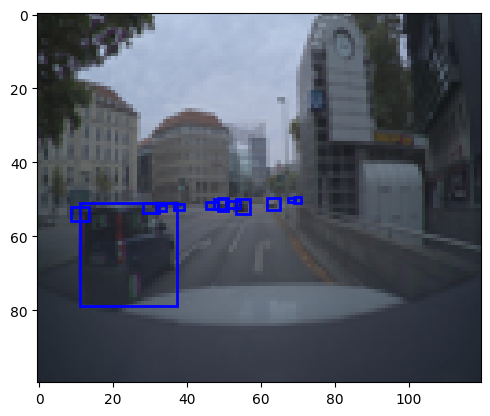

In [12]:
image_tensor = data[0].permute(1, 2, 0)
box_coordinates = data[1]["boxes"]

plt.imshow(image_tensor)

for bbox in box_coordinates:

    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[2]
    max_y = bbox[3]
    width = max_x - min_x
    height = max_y - min_y
    plt.gca().add_patch(Rectangle((min_x, min_y), width, height, edgecolor='b', facecolor='none', linewidth=2))
plt.show()

In [13]:
# restore original image and recalculate bounding boxes
# image id: 37620

In [14]:
image_id = "037620"

In [15]:
def visualize_img(id):
    image_path = f"../../../mnt/nfs_mount/single_frames/{id}/camera_front_blur/"
    image_files = glob.glob(image_path + "*.jpg")
    if len(image_files) > 0:
        image = Image.open(image_files[0])
      #  image.show()
    return image

In [16]:
def get_annotations_unscaled(id):
    annotation_path = f"../../../mnt/nfs_mount/single_frames/{id}/annotations/object_detection/"
    annotation_file = glob.glob(annotation_path + "*.json")
    f = open(annotation_file[0])
    annotation_list = json.load(f)

    column_names = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max']
    df = pd.DataFrame(columns=column_names)

    # load image to get shape
    image_path = f"../../../mnt/nfs_mount/single_frames/{id}/camera_front_blur/"
    image_files = glob.glob(image_path + "*.jpg")
    if len(image_files) > 0:
        image = Image.open(image_files[0])
    size = image.size

    # only get cars
    for annotation in annotation_list:
        if annotation["properties"]["class"] == "Vehicle":
            # get bounding boxes
            box_coordinates = annotation["geometry"]["coordinates"]

            # Rescale bounding boxes 
            min_x = min(coord[0] for coord in box_coordinates) 
            min_y = min(coord[1] for coord in box_coordinates)
            max_x = max(coord[0] for coord in box_coordinates) 
            max_y = max(coord[1] for coord in box_coordinates) 

            new_row = {"image_id": id, "x_min": min_x, "y_min": min_y, "x_max": max_x, "y_max": max_y}
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df

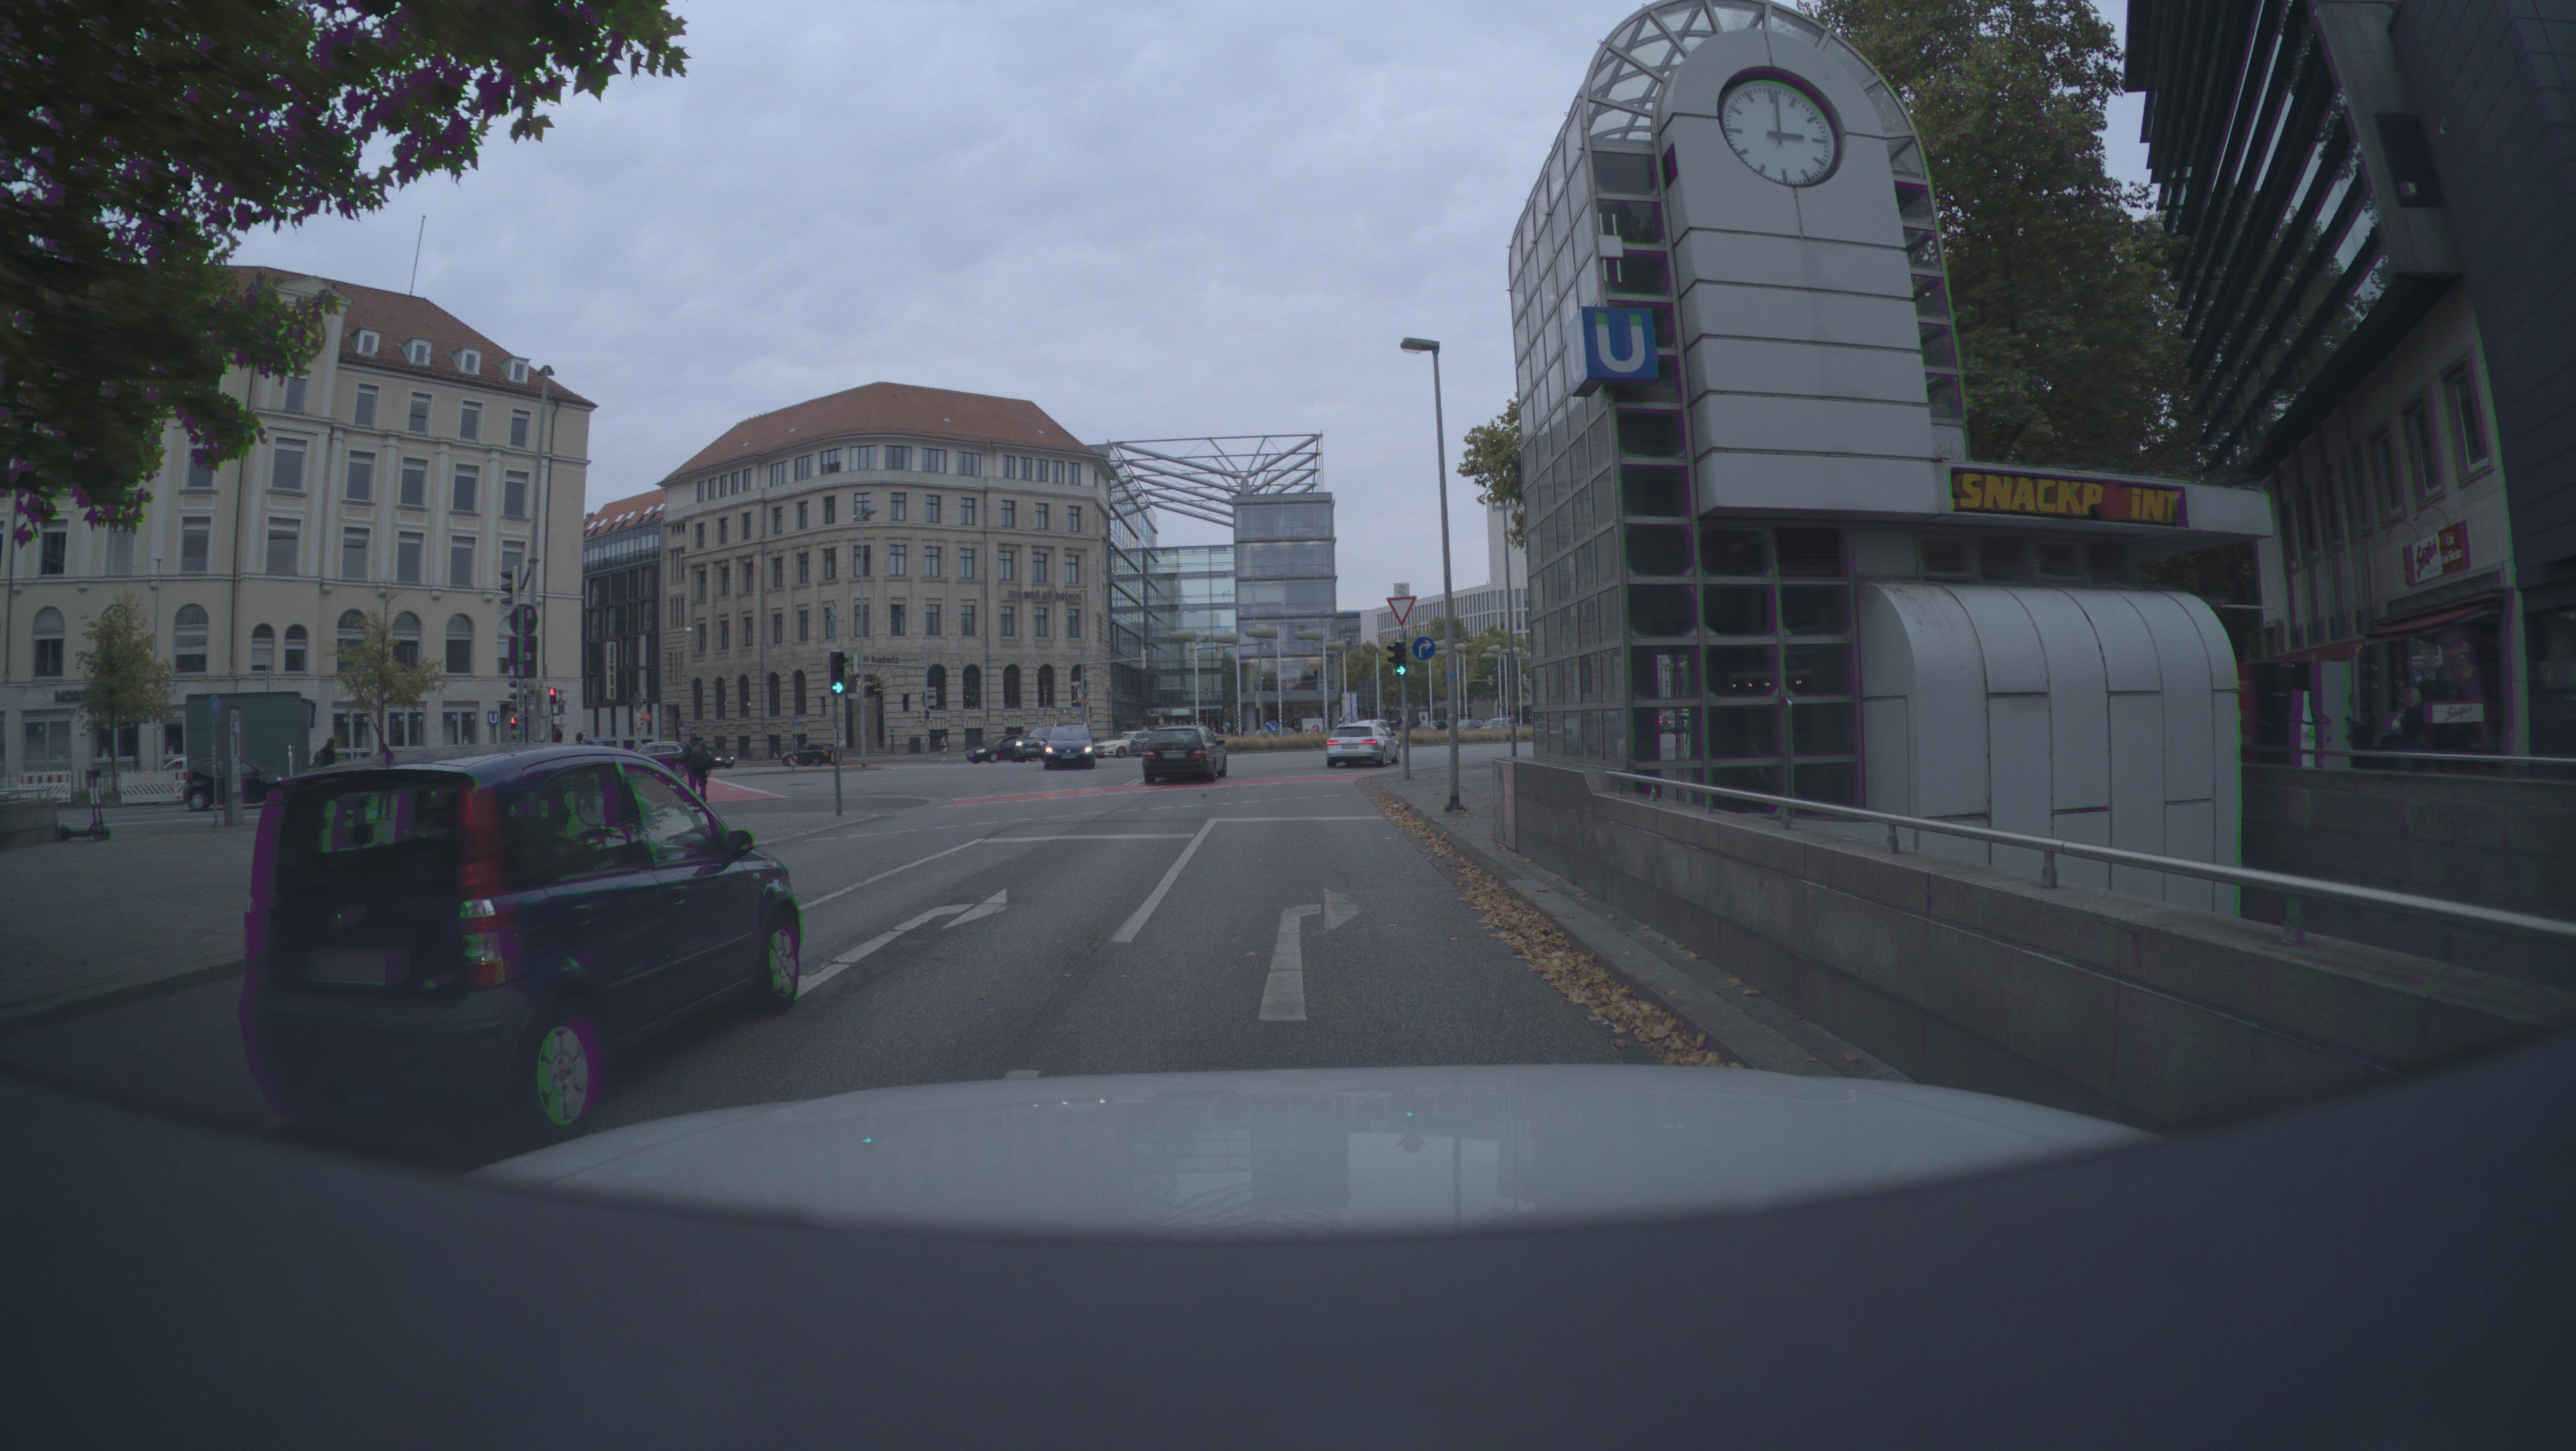

In [17]:
visualize_img(image_id)

In [18]:
image_path = f"../../../mnt/nfs_mount/single_frames/{image_id}/camera_front_blur/"
image_path

'../../../mnt/nfs_mount/single_frames/037620/camera_front_blur/'

In [19]:
annotation_df = get_annotations_unscaled(image_id)
annotation_df


image_id        x_min        y_min        x_max        y_max
0    037620  1980.228394  1078.127529  2091.519043  1148.279541
1    037620  1872.748030  1086.061055  1938.095459  1113.287354
2    037620  1015.968933  1115.289185  1097.183350  1151.892822
3    037620   848.850342  1103.819290   922.886138  1135.707153
4    037620  1515.723389  1083.375366  1620.501343  1139.882202
5    037620   221.376740  1129.982910   351.136749  1192.248471
6    037620   904.086939  1107.678307  1038.468872  1163.951294
7    037620  2000.952148  1075.131470  2077.340088  1109.105713
8    037620  1634.461670  1091.825073  1743.440006  1134.455078
9    037620  1555.013184  1078.106934  1640.922607  1149.950562
10   037620  1705.841553  1079.621704  1833.082642  1171.427979
11   037620  1168.290039  1110.090210  1257.343018  1146.002563
12   037620  1443.092285  1097.350952  1552.285278  1141.756104
13   037620  2158.002686  1074.210269  2219.150635  1101.697521
14   037620   272.786713  1130.836792   433.664307  1213.034790
15   037620  2207.746094  1071.498147  2267.195557  1103.235229
16   037620   351.825897  1106.535522  1197.861328  1708.597290
17   037620  2492.278076  1065.460815  2554.274170  1096.807251
18   037620  2477.649658  1066.157471  2526.410889  1096.807251
19   037620  2132.597168  1076.962280  2175.401367  1094.912476
20   037620  2098.293701  1079.543335  2131.008057  1093.269775
21   037620  2060.088623  1077.255615  2093.718262  1096.243774
22   037620  1779.367310  1090.784424  1829.223267  1109.383545

In [20]:
data = annotation_df
num_boxes = len(data)

box_coordinates = []
for i in range(num_boxes):
    box_coordinates.append(torch.tensor(data.iloc[i][["x_min", "y_min", "x_max", "y_max"]].astype("float").to_numpy()))

if num_boxes > 1:
    box_coordinates = torch.stack(box_coordinates, axis=0)
elif num_boxes == 1:
    box_coordinates = box_coordinates[0]
    box_coordinates = box_coordinates.view(1,4)
else:
    pass
box_coordinates

tensor([[1980.2284, 1078.1275, 2091.5190, 1148.2795],
        [1872.7480, 1086.0611, 1938.0955, 1113.2874],
        [1015.9689, 1115.2892, 1097.1833, 1151.8928],
        [ 848.8503, 1103.8193,  922.8861, 1135.7072],
        [1515.7234, 1083.3754, 1620.5013, 1139.8822],
        [ 221.3767, 1129.9829,  351.1367, 1192.2485],
        [ 904.0869, 1107.6783, 1038.4689, 1163.9513],
        [2000.9521, 1075.1315, 2077.3401, 1109.1057],
        [1634.4617, 1091.8251, 1743.4400, 1134.4551],
        [1555.0132, 1078.1069, 1640.9226, 1149.9506],
        [1705.8416, 1079.6217, 1833.0826, 1171.4280],
        [1168.2900, 1110.0902, 1257.3430, 1146.0026],
        [1443.0923, 1097.3510, 1552.2853, 1141.7561],
        [2158.0027, 1074.2103, 2219.1506, 1101.6975],
        [ 272.7867, 1130.8368,  433.6643, 1213.0348],
        [2207.7461, 1071.4981, 2267.1956, 1103.2352],
        [ 351.8259, 1106.5355, 1197.8613, 1708.5973],
        [2492.2781, 1065.4608, 2554.2742, 1096.8073],
        [2477.6497, 1066.157

In [21]:
img = visualize_img(image_id)

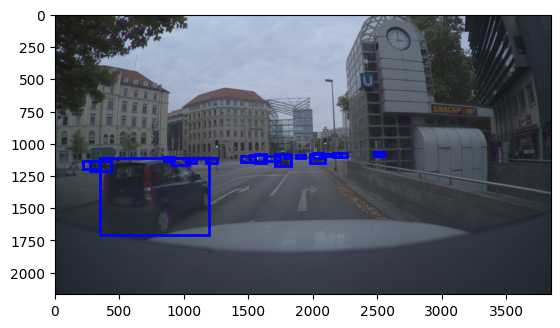

In [22]:
plt.imshow(img)

for bbox in box_coordinates:

    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[2]
    max_y = bbox[3]

    width = max_x - min_x
    height = max_y - min_y

    plt.gca().add_patch(Rectangle((min_x, min_y), width, height, edgecolor='b', facecolor='none', linewidth=2))
plt.show()

In [23]:
# predicted

In [24]:
img.size

(3848, 2168)

In [25]:
image_tensor.shape

torch.Size([100, 120, 3])

In [26]:
box_coordinates

tensor([[1980.2284, 1078.1275, 2091.5190, 1148.2795],
        [1872.7480, 1086.0611, 1938.0955, 1113.2874],
        [1015.9689, 1115.2892, 1097.1833, 1151.8928],
        [ 848.8503, 1103.8193,  922.8861, 1135.7072],
        [1515.7234, 1083.3754, 1620.5013, 1139.8822],
        [ 221.3767, 1129.9829,  351.1367, 1192.2485],
        [ 904.0869, 1107.6783, 1038.4689, 1163.9513],
        [2000.9521, 1075.1315, 2077.3401, 1109.1057],
        [1634.4617, 1091.8251, 1743.4400, 1134.4551],
        [1555.0132, 1078.1069, 1640.9226, 1149.9506],
        [1705.8416, 1079.6217, 1833.0826, 1171.4280],
        [1168.2900, 1110.0902, 1257.3430, 1146.0026],
        [1443.0923, 1097.3510, 1552.2853, 1141.7561],
        [2158.0027, 1074.2103, 2219.1506, 1101.6975],
        [ 272.7867, 1130.8368,  433.6643, 1213.0348],
        [2207.7461, 1071.4981, 2267.1956, 1103.2352],
        [ 351.8259, 1106.5355, 1197.8613, 1708.5973],
        [2492.2781, 1065.4608, 2554.2742, 1096.8073],
        [2477.6497, 1066.157

In [27]:
boxes

tensor([[61.7535, 49.7291, 65.2241, 52.9649],
        [31.6830, 51.4432, 34.2157, 53.1316],
        [47.2679, 49.9712, 50.5354, 52.5776],
        [28.1940, 51.0922, 32.3847, 53.6878],
        [50.9707, 50.3609, 54.3692, 52.3273],
        [48.4931, 49.7282, 51.1722, 53.0420],
        [53.1967, 49.7980, 57.1647, 54.0327],
        [36.4332, 51.2034, 39.2103, 52.8599],
        [45.0029, 50.6158, 48.4081, 52.6640],
        [67.2974, 49.5484, 69.2043, 50.8163],
        [ 8.5069, 52.1604, 13.5238, 55.9518],
        [68.8486, 49.4233, 70.7026, 50.8872],
        [10.9717, 51.0395, 37.3553, 78.8098]], dtype=torch.float64)

In [28]:
# resized image:
# width: 120, height: 100
# original image:
# width: 3848, 2168

column_names = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max']
df = pd.DataFrame(columns=column_names)

new_size = (3848, 2168)
size = (120, 100)

scale_x = new_size[0] / size[0]
scale_y = new_size[1] / size[1]

In [29]:
rescaled_boxes = []
for box in boxes:
    min_x = box[0] * scale_x
    min_y = box[1] * scale_y
    max_x = box[2] * scale_x
    max_y = box[3] * scale_y
    rescaled_boxes.append([int(min_x), int(min_y), int(max_x), int(max_y)])
rescaled_boxes

[[1980, 1078, 2091, 1148],
 [1015, 1115, 1097, 1151],
 [1515, 1083, 1620, 1139],
 [904, 1107, 1038, 1163],
 [1634, 1091, 1743, 1134],
 [1555, 1078, 1640, 1149],
 [1705, 1079, 1833, 1171],
 [1168, 1110, 1257, 1146],
 [1443, 1097, 1552, 1141],
 [2158, 1074, 2219, 1101],
 [272, 1130, 433, 1213],
 [2207, 1071, 2267, 1103],
 [351, 1106, 1197, 1708]]

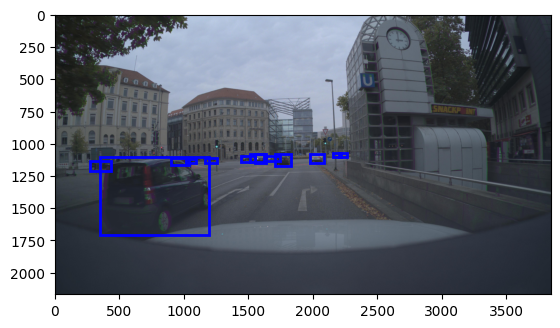

In [30]:
plt.imshow(img)

for bbox in rescaled_boxes:

    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[2]
    max_y = bbox[3]

    width = max_x - min_x
    height = max_y - min_y

    plt.gca().add_patch(Rectangle((min_x, min_y), width, height, edgecolor='b', facecolor='none', linewidth=2))
plt.show()